In [58]:
'''Basic Libraries'''
import pandas as pd 
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt 
import os.path 
import regex as re
import warnings 
import zipfile
import idx2numpy 
import itertools
from PIL import Image
import cv2
import math
warnings.filterwarnings('ignore')


'''Preprocessing and CNN Libraries'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, AveragePooling2D, Input, Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
test_img_path = '/content/drive/MyDrive/TEST_MNIST/t10k-images-idx3-ubyte.gz/t10k-images.idx3-ubyte'
test_label_path = '/content/drive/MyDrive/TEST_MNIST/t10k-labels-idx1-ubyte.gz/t10k-labels.idx1-ubyte'

In [50]:
#CONFIG 
TRAIN_DIR = '/content/dataset/mnistTask' 
NUM_CLASSES = 10
n = 3
BATCH_SIZE = 128
EPOCHS = 100
IMG_HEIGHT = 28 
IMG_WIDTH = 28
CHANNELS = 1
RANDOM_STATE = 2018

# __Data Collection and Preprocessing__

__Converting Train images into n dimensional arrays__ 

In [63]:
filepaths = list(Path(TRAIN_DIR).glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

#Concatenating filepaths and image labels into a dataframe
image_df = pd.concat([filepaths, labels], axis=1)

# Now We need to extract values of each pixel from our Images and store them in a ndarray so that our model can learn them better.
train_files = [] 
for _file in filepaths:
  train_files.append(_file) #Append the path names for each image 

dataset = np.ndarray(shape=(len(train_files), IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.float32)

i=0
for _file in train_files:
  img = Image.open(_file)
  img = img.convert('L')
  img = np.expand_dims(img, axis=-1)
  dataset[i] = img
  i += 1

__Converting MNIST test images into n dimensional arrays__ 

In [67]:
#extracting the iamges and converting them into arrays
X_test = idx2numpy.convert_from_file(test_img_path)

#Reshape all the images into (w,d,c)
X_test = X_test.reshape(len(X_test), IMG_HEIGHT, IMG_WIDTH, CHANNELS)

#same goes with labels
y_test = idx2numpy.convert_from_file(test_label_path)

y_test = y_test.reshape(-1,1)

In [68]:
X_train = dataset
y_train = image_df['Label'].values.reshape(-1,1)

In [70]:
# storing the inputs of image dimensions in a variable.
input_shape = X_train.shape[1:]

# normalizing data. As we want values to be scaled within a range of 0 to 255 because CNN converges faster on scale of 0 to 1 rather 
# then on a scale of 0 to 255.
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Subtracting pixel improves accuracy
x_train_mean = np.mean(X_train, axis=0)
x_test_mean = np.mean(X_test, axis=0)
X_train -= x_train_mean
X_test -= x_test_mean

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 1)


In [71]:
# convert class vectoars to binary class matrices.
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [72]:
# Perform data augmentation so that it done lead o overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1, # randomly shift images vertically
        horizontal_flip=True,   # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically

datagen.fit(X_train)

# How many images should each Epoch should consist.
steps_per_epoch =  math.ceil(len(X_train) / BATCH_SIZE)

In [73]:
#As we have a comparatively small dataset, we need to Augment the images so that our model will generalize better

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1, # randomly shift images vertically
        horizontal_flip=True,   # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically

datagen.fit(X_train)

# How many images should each Epoch should consist.
steps_per_epoch =  math.ceil(len(X_train) / BATCH_SIZE)

# Model Building

For this task I am using the same model from task 1 but training it from scratch and randomly initializing weighs again. 

The architecture of the model is quite same as it was for the part 1. 
  

In [74]:
# Depth shows how deep the neural network should be built. 

version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2


def resnet_layer(inputs, 
                 num_filters=16, 
                 kernel_size=3, 
                 strides=1, 
                 activation = 'relu', 
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
    
def resnet_v1(input_shape, depth, num_classes=NUM_CLASSES):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=4)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [75]:
#Crating a directory to save both the models 

save_dir = os.path.join(os.getcwd(), 'task_3_models')
pretrained_name = 'task3_pretrained_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
pretrained_filepath = os.path.join(save_dir,pretrained_name)

In [76]:
# Defining some Callbacks 

# For reusing the best model, I am defining a checkoint so that the model with the best learned parameters can be saved
checkpoint = ModelCheckpoint(filepath=pretrained_filepath,monitor='val_acc',verbose=1,save_best_only=True)

#Reducing the LR by sqrt(0.1) factor if the accuracy is not imporved after 5 epochs 
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]

In [77]:
model = resnet_v1(input_shape=input_shape, depth=depth)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 28, 28, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 28, 28, 16)   64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 28, 28, 16)   0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [78]:
# Compiling our model and fitting it on our dataset
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['acc'])

history  = model.fit(x=datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
              verbose=1,
              epochs=EPOCHS,
              validation_data=(X_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

Epoch 1/100
469/469 [==============================] - 39s 76ms/step - loss: 2.5558 - acc: 0.1049 - val_loss: 3.0084 - val_acc: 0.0116

Epoch 00001: val_acc improved from -inf to 0.01160, saving model to /content/task_3_models/task3_pretrained_model.h5
Epoch 2/100
469/469 [==============================] - 35s 74ms/step - loss: 2.4300 - acc: 0.1101 - val_loss: 3.0027 - val_acc: 0.0058

Epoch 00002: val_acc did not improve from 0.01160
Epoch 3/100
469/469 [==============================] - 35s 74ms/step - loss: 2.4043 - acc: 0.1082 - val_loss: 3.4190 - val_acc: 0.0055

Epoch 00003: val_acc did not improve from 0.01160
Epoch 4/100
469/469 [==============================] - 35s 74ms/step - loss: 2.3770 - acc: 0.1117 - val_loss: 3.5016 - val_acc: 0.0073

Epoch 00004: val_acc did not improve from 0.01160
Epoch 5/100
469/469 [==============================] - 35s 74ms/step - loss: 2.3526 - acc: 0.1130 - val_loss: 3.8908 - val_acc: 0.0031

Epoch 00005: val_acc did not improve from 0.01160
Epo

# __Evaluating Performance__

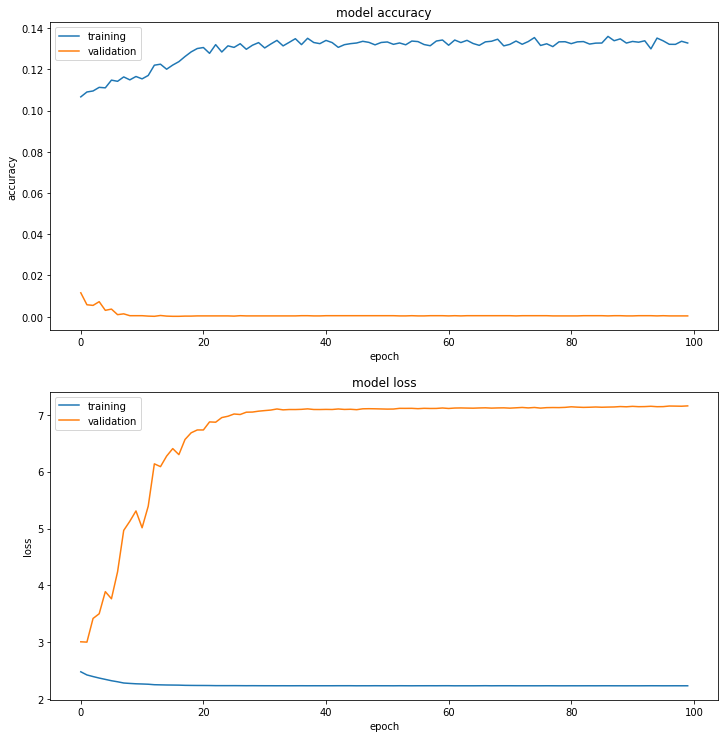

In [79]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [81]:
#Lets check the score for our model
model_score = model.evaluate(X_test, y_test)
print('The loss and val accuracy for model one is {} and {}'.format(model_score[0], model_score[1]))

313/313 [==============================] - 3s 9ms/step - loss: 7.1571 - acc: 4.0000e-04
The loss and val accuracy for model one is 7.157060146331787 and 0.00039999998989515007


__Observations:__

- The accuracy is so low, but this is reasonable as the dataset is so noisy. Its filled with all the other images rather than labelled images. 
- Wherease the test dataset (MNIST test dataset), the dataset isnt filled with any noise or so. And the coresspoding images belong to the same dataset.


In [82]:
#lets also check the misclassificaion error
#We are simpaly going to check out how our model has performed in identifying the right label for each of the images present in 
#test dataset

def prdict_right_classes(model):
    predicted_classes = model.predict(X_test)
    prediction = np.argmax(predicted_classes, axis=-1)
    class_idx = np.argmax(y_test, axis=-1)

    #compare them wether they are rightly classifid or not
    correct = np.nonzero(prediction==class_idx)[0]
    incorrect = np.nonzero(prediction!=class_idx)[0]
    return correct.shape[0], incorrect.shape[0]

model_preds = prdict_right_classes(model)
print('Correct predictions: {} | Incorrect Predictions: {}'.format(model_preds[0], model_preds[1]))

Correct predictions: 4 | Incorrect Predictions: 9996


### I was a little bit skeptical about this question as we were being told to use pretrained model from scratch and provide test accuracy. 

### So two methods were coming to my mind:
#### 1. Taking this whole noisy dataset as our training dataset and using MNIST test dataset as our validation dataset.
#### 2. Splitting this dataset into train and validation dataset and than using the trained model to on MNIST dataset and than providing the test accuracy.

I didn't want to left out on any part, so I went away with both these methods.